# Input 32 Output 32

In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices(device_type=None)

import tensorflow.keras as keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py


from tensorflow.keras.layers import MultiHeadAttention,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate
from tensorflow.keras import callbacks 

from sklearn.model_selection import KFold

In [2]:
import os
path, dirs, files = next(os.walk("Out1"))
file_count = len(files)
print('The number of profiles:',file_count)

The number of profiles: 4000


In [3]:
# load data -------------------------------------------------

num = 4000 # number of profiles
nchan = 3 # number of channels

# get spatial dimension
fname = "Out1/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

data = np.empty((num, x_size, nchan+1), dtype=float)
for i in range(0, num):
    fname = "Out1/profile_%05d.hdf5" %(i+1)
    hf = h5py.File(fname, 'r')
    data[i, :, 0] = np.array(hf.get("red"))
    data[i, :, 1] = np.array(hf.get("grn"))
    data[i, :, 2] = np.array(hf.get("blu"))
    data[i, :, 3] = np.array(hf.get("tau")) #data.shape: (4000, 4096, 4) 4000 profiles, 4096 pixels, 3 channels 
    hf.close()

np.random.seed(4); #same set of numbers will appear every time
np.random.shuffle(data) #number will be in the same order in data

# allocate for training and testing -------------------------
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

# spatial slicing dimensions
os = 32 # output slice size
ts = os # total input slice:31 size including halos 
ks = int(ts / 2) # kernel size is half of total size 6
l2r = 128 # number of slices in one profile 



In [4]:
print("train_size:",train_size)
print("test_size:",test_size)

train_size: 3200
test_size: 800


In [5]:
# spatial slicing the profiles

image=np.zeros((l2r*num,ts,nchan)) 
label=np.zeros((l2r*num,os)) 

for i in range(num):
    for a in range(l2r):
#cut each profile into 128 slices. 
#label: tau channel 
#1profile ..2profile...3 profile

        img= data[i, a*os:a*os+ts, 0:nchan] #input: 32 pixels for one slice, 3 channels 
        lb = data[i, a*os:a*os+os, nchan] #32 pixels for label,the tau channel is the label
        image[i*l2r+a]=img
        label[i*l2r+a]=lb 
print('whole dataset features size: ',image.shape,'whole dataset label size: ', label.shape) 


whole dataset features size:  (512000, 32, 3) whole dataset label size:  (512000, 32)


In [7]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024
eps = 2000


    #bi-LSTM
input_layer = tf.keras.layers.Input(shape=(ts,nchan),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
projection=tf.keras.layers.Dense(32,activation='relu')(input_layer)
positions = tf.range(start=0, limit=32, delta=1)
embedding=tf.keras.layers.Embedding(input_dim=(96),output_dim=(32),input_length=32)(positions)
    # adds a learnable position embedding to the projected vector
encoded = projection+embedding

bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel

    #position_embedding=layers.Embedding(input_dim=256, output_dim=256,input_length=32)(bi)

    #transformer block
slf_attn = MultiHeadAttention(num_heads=3,key_dim=128)(bi,bi)
add1=tf.keras.layers.Add()([slf_attn,bi])
layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
add2=tf.keras.layers.Add()([layernorm1,dense1])
layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)

    #pooling
avg_pool = GlobalAveragePooling1D()(layernorm2)
max_pool = GlobalMaxPooling1D()(layernorm2)
conc = concatenate([avg_pool, max_pool])

    #output layers
dense2 = tf.keras.layers.Dense(128,activation='relu')(conc)
output = tf.keras.layers.Dense(os,activation='relu')(dense2)

model = tf.keras.models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 32, 32)       128         Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 32, 32)       0           dense[0][0]                      
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 32, 256)      164864      tf.__operators__.add[0][0]       
______________________________________________________________________________________________

In [8]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [9]:
ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 1024
eps = 2000

def eval_model(train_image, test_image, train_label, test_label):

    #bi-LSTM
    input_layer = tf.keras.layers.Input(shape=(ts,nchan),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(96,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=32, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(96),output_dim=(96),input_length=32)(positions)
    # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(encoded) #kernel size 6, 100 filters for each 3 channel
    bi=Bidirectional(tf.keras.layers.LSTM(units=128, activation='tanh',return_sequences = True))(bi) #kernel size 6, 100 filters for each 3 input_layerchannel

    #position_embedding=layers.Embedding(input_dim=256, output_dim=256,input_length=32)(bi)

    #transformer block
    slf_attn = MultiHeadAttention(num_heads=3,key_dim=128)(bi,bi)
    add1=tf.keras.layers.Add()([slf_attn,bi])
    layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add1)
    dense1=tf.keras.layers.Dense(256,activation='relu')(layernorm1)
    add2=tf.keras.layers.Add()([layernorm1,dense1])
    layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)(add2)

    #pooling
    avg_pool = GlobalAveragePooling1D()(layernorm2)
    max_pool = GlobalMaxPooling1D()(layernorm2)
    conc = concatenate([avg_pool, max_pool])

    #output layers
    dense2 = tf.keras.layers.Dense(128,activation='relu')(conc)
    output = tf.keras.layers.Dense(os,activation='relu')(dense2)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])

    model.summary()
    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(10%)/trainset(80%)=0.125

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]
    
    return model,rmse,mse,history,predictions

In [10]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(image),'folds cross validation')
print(kf)
ratio=int(image.shape[0]/n_folds)

X_train=np.zeros((n_folds,ratio*(n_folds-1),ts,3))
y_train=np.zeros((n_folds,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts,3))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(image):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = image[train_index], image[test_index]
    y_train[count], y_test[count] = label[train_index], label[test_index]
    count+=1

5 folds cross validation
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [102400 102401 102402 ... 511997 511998 511999] TEST: [     0      1      2 ... 102397 102398 102399]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [102400 102401 102402 ... 204797 204798 204799]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [204800 204801 204802 ... 307197 307198 307199]
TRAIN: [     0      1      2 ... 511997 511998 511999] TEST: [307200 307201 307202 ... 409597 409598 409599]
TRAIN: [     0      1      2 ... 409597 409598 409599] TEST: [409600 409601 409602 ... 511997 511998 511999]


In [11]:
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 3)]      0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32, 96)       384         Input[0][0]                      
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 32, 96)       0           dense_4[0][0]                    
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 32, 256)      230400      tf.__operators__.add_1[0][0]     
____________________________________________________________________________________________

350/350 [==============================] - 24s 68ms/step - loss: 2.8115 - mean_squared_error: 2.8115 - root_mean_squared_error: 1.6758 - val_loss: 3.5149 - val_mean_squared_error: 3.5149 - val_root_mean_squared_error: 1.8748
Epoch 53/2000
350/350 [==============================] - 24s 68ms/step - loss: 2.6335 - mean_squared_error: 2.6335 - root_mean_squared_error: 1.6220 - val_loss: 3.3450 - val_mean_squared_error: 3.3450 - val_root_mean_squared_error: 1.8289
Epoch 54/2000
350/350 [==============================] - 24s 68ms/step - loss: 2.1508 - mean_squared_error: 2.1508 - root_mean_squared_error: 1.4665 - val_loss: 4.1976 - val_mean_squared_error: 4.1976 - val_root_mean_squared_error: 2.0488
Epoch 55/2000
350/350 [==============================] - 24s 68ms/step - loss: 2.4867 - mean_squared_error: 2.4867 - root_mean_squared_error: 1.5758 - val_loss: 4.0174 - val_mean_squared_error: 4.0174 - val_root_mean_squared_error: 2.0043
Epoch 56/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 67ms/step - loss: 0.5364 - mean_squared_error: 0.5364 - root_mean_squared_error: 0.7324 - val_loss: 1.2725 - val_mean_squared_error: 1.2725 - val_root_mean_squared_error: 1.1281
Epoch 121/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.5230 - mean_squared_error: 0.5230 - root_mean_squared_error: 0.7231 - val_loss: 1.2059 - val_mean_squared_error: 1.2059 - val_root_mean_squared_error: 1.0982
Epoch 122/2000
350/350 [==============================] - 24s 67ms/step - loss: 1.1513 - mean_squared_error: 1.1513 - root_mean_squared_error: 1.0265 - val_loss: 2.7136 - val_mean_squared_error: 2.7136 - val_root_mean_squared_error: 1.6473
Epoch 123/2000
350/350 [==============================] - 24s 68ms/step - loss: 1.4390 - mean_squared_error: 1.4390 - root_mean_squared_error: 1.1965 - val_loss: 1.4429 - val_mean_squared_error: 1.4429 - val_root_mean_squared_error: 1.2012
Epoch 124/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 0.3447 - mean_squared_error: 0.3447 - root_mean_squared_error: 0.5871 - val_loss: 0.8807 - val_mean_squared_error: 0.8807 - val_root_mean_squared_error: 0.9384
Epoch 189/2000
350/350 [==============================] - 24s 68ms/step - loss: 1.3500 - mean_squared_error: 1.3500 - root_mean_squared_error: 1.1057 - val_loss: 2.0648 - val_mean_squared_error: 2.0648 - val_root_mean_squared_error: 1.4369
Epoch 190/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.9228 - mean_squared_error: 0.9228 - root_mean_squared_error: 0.9597 - val_loss: 1.2405 - val_mean_squared_error: 1.2405 - val_root_mean_squared_error: 1.1138
Epoch 191/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.4631 - mean_squared_error: 0.4631 - root_mean_squared_error: 0.6803 - val_loss: 1.0772 - val_mean_squared_error: 1.0772 - val_root_mean_squared_error: 1.0379
Epoch 192/2000
350/350 [==============================]

350/350 [==============================] - 31s 71ms/step - loss: 36.8043 - mean_squared_error: 36.8043 - root_mean_squared_error: 4.3088 - val_loss: 16.6396 - val_mean_squared_error: 16.6396 - val_root_mean_squared_error: 4.0792
Epoch 2/2000
350/350 [==============================] - 24s 68ms/step - loss: 20.5647 - mean_squared_error: 20.5647 - root_mean_squared_error: 4.5340 - val_loss: 18.4255 - val_mean_squared_error: 18.4255 - val_root_mean_squared_error: 4.2925
Epoch 3/2000
350/350 [==============================] - 24s 67ms/step - loss: 19.7614 - mean_squared_error: 19.7614 - root_mean_squared_error: 4.4444 - val_loss: 15.6135 - val_mean_squared_error: 15.6135 - val_root_mean_squared_error: 3.9514
Epoch 4/2000
350/350 [==============================] - 24s 68ms/step - loss: 17.8808 - mean_squared_error: 17.8808 - root_mean_squared_error: 4.2282 - val_loss: 16.0853 - val_mean_squared_error: 16.0853 - val_root_mean_squared_error: 4.0106
Epoch 5/2000
350/350 [=======================

350/350 [==============================] - 24s 68ms/step - loss: 6.0577 - mean_squared_error: 6.0577 - root_mean_squared_error: 2.4602 - val_loss: 5.8382 - val_mean_squared_error: 5.8382 - val_root_mean_squared_error: 2.4162
Epoch 36/2000
350/350 [==============================] - 24s 67ms/step - loss: 5.5818 - mean_squared_error: 5.5818 - root_mean_squared_error: 2.3623 - val_loss: 6.0853 - val_mean_squared_error: 6.0853 - val_root_mean_squared_error: 2.4668
Epoch 37/2000
350/350 [==============================] - 24s 68ms/step - loss: 5.6148 - mean_squared_error: 5.6148 - root_mean_squared_error: 2.3694 - val_loss: 5.8014 - val_mean_squared_error: 5.8014 - val_root_mean_squared_error: 2.4086
Epoch 38/2000
350/350 [==============================] - 24s 67ms/step - loss: 5.5772 - mean_squared_error: 5.5772 - root_mean_squared_error: 2.3615 - val_loss: 5.6325 - val_mean_squared_error: 5.6325 - val_root_mean_squared_error: 2.3733
Epoch 39/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 68ms/step - loss: 1.3940 - mean_squared_error: 1.3940 - root_mean_squared_error: 1.1806 - val_loss: 2.9055 - val_mean_squared_error: 2.9055 - val_root_mean_squared_error: 1.7045
Epoch 104/2000
350/350 [==============================] - 24s 67ms/step - loss: 1.3255 - mean_squared_error: 1.3255 - root_mean_squared_error: 1.1510 - val_loss: 3.2771 - val_mean_squared_error: 3.2771 - val_root_mean_squared_error: 1.8103
Epoch 105/2000
350/350 [==============================] - 24s 67ms/step - loss: 1.7640 - mean_squared_error: 1.7640 - root_mean_squared_error: 1.3274 - val_loss: 3.2104 - val_mean_squared_error: 3.2104 - val_root_mean_squared_error: 1.7918
Epoch 106/2000
350/350 [==============================] - 24s 68ms/step - loss: 1.6698 - mean_squared_error: 1.6698 - root_mean_squared_error: 1.2916 - val_loss: 4.1640 - val_mean_squared_error: 4.1640 - val_root_mean_squared_error: 2.0406
Epoch 107/2000
350/350 [==============================]

350/350 [==============================] - 24s 67ms/step - loss: 0.6315 - mean_squared_error: 0.6315 - root_mean_squared_error: 0.7946 - val_loss: 1.9199 - val_mean_squared_error: 1.9199 - val_root_mean_squared_error: 1.3856
Epoch 172/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.5787 - mean_squared_error: 0.5787 - root_mean_squared_error: 0.7607 - val_loss: 1.9140 - val_mean_squared_error: 1.9140 - val_root_mean_squared_error: 1.3835
Epoch 173/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.5571 - mean_squared_error: 0.5571 - root_mean_squared_error: 0.7464 - val_loss: 1.9414 - val_mean_squared_error: 1.9414 - val_root_mean_squared_error: 1.3934
Epoch 174/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.5577 - mean_squared_error: 0.5577 - root_mean_squared_error: 0.7467 - val_loss: 1.9629 - val_mean_squared_error: 1.9629 - val_root_mean_squared_error: 1.4010
Epoch 175/2000
350/350 [==============================]

350/350 [==============================] - 24s 67ms/step - loss: 1.0689 - mean_squared_error: 1.0689 - root_mean_squared_error: 1.0316 - val_loss: 1.8867 - val_mean_squared_error: 1.8867 - val_root_mean_squared_error: 1.3736
Epoch 240/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.4970 - mean_squared_error: 0.4970 - root_mean_squared_error: 0.7049 - val_loss: 1.8560 - val_mean_squared_error: 1.8560 - val_root_mean_squared_error: 1.3623
Epoch 241/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.4139 - mean_squared_error: 0.4139 - root_mean_squared_error: 0.6433 - val_loss: 1.8307 - val_mean_squared_error: 1.8307 - val_root_mean_squared_error: 1.3530
Epoch 242/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.3829 - mean_squared_error: 0.3829 - root_mean_squared_error: 0.6188 - val_loss: 1.7943 - val_mean_squared_error: 1.7943 - val_root_mean_squared_error: 1.3395
Epoch 243/2000
350/350 [==============================]

350/350 [==============================] - 30s 71ms/step - loss: 39.9099 - mean_squared_error: 39.9099 - root_mean_squared_error: 4.5672 - val_loss: 22.0161 - val_mean_squared_error: 22.0161 - val_root_mean_squared_error: 4.6921
Epoch 2/2000
350/350 [==============================] - 24s 68ms/step - loss: 24.9492 - mean_squared_error: 24.9492 - root_mean_squared_error: 4.9946 - val_loss: 23.1712 - val_mean_squared_error: 23.1712 - val_root_mean_squared_error: 4.8136
Epoch 3/2000
350/350 [==============================] - 24s 67ms/step - loss: 21.2047 - mean_squared_error: 21.2047 - root_mean_squared_error: 4.6043 - val_loss: 16.0492 - val_mean_squared_error: 16.0492 - val_root_mean_squared_error: 4.0062
Epoch 4/2000
350/350 [==============================] - 24s 67ms/step - loss: 19.8067 - mean_squared_error: 19.8067 - root_mean_squared_error: 4.4503 - val_loss: 16.8696 - val_mean_squared_error: 16.8696 - val_root_mean_squared_error: 4.1073
Epoch 5/2000
350/350 [=======================

350/350 [==============================] - 24s 68ms/step - loss: 2.4700 - mean_squared_error: 2.4700 - root_mean_squared_error: 1.5715 - val_loss: 3.3097 - val_mean_squared_error: 3.3097 - val_root_mean_squared_error: 1.8192
Epoch 70/2000
350/350 [==============================] - 24s 68ms/step - loss: 2.5261 - mean_squared_error: 2.5261 - root_mean_squared_error: 1.5884 - val_loss: 4.8793 - val_mean_squared_error: 4.8793 - val_root_mean_squared_error: 2.2089
Epoch 71/2000
350/350 [==============================] - 24s 68ms/step - loss: 3.0176 - mean_squared_error: 3.0176 - root_mean_squared_error: 1.7315 - val_loss: 3.2805 - val_mean_squared_error: 3.2805 - val_root_mean_squared_error: 1.8112
Epoch 72/2000
350/350 [==============================] - 24s 67ms/step - loss: 2.2118 - mean_squared_error: 2.2118 - root_mean_squared_error: 1.4865 - val_loss: 2.9345 - val_mean_squared_error: 2.9345 - val_root_mean_squared_error: 1.7130
Epoch 73/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 68ms/step - loss: 3.2867 - mean_squared_error: 3.2867 - root_mean_squared_error: 1.8053 - val_loss: 2.2938 - val_mean_squared_error: 2.2938 - val_root_mean_squared_error: 1.5145
Epoch 138/2000
350/350 [==============================] - 24s 67ms/step - loss: 1.0904 - mean_squared_error: 1.0904 - root_mean_squared_error: 1.0430 - val_loss: 1.3955 - val_mean_squared_error: 1.3955 - val_root_mean_squared_error: 1.1813
Epoch 139/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.6915 - mean_squared_error: 0.6915 - root_mean_squared_error: 0.8316 - val_loss: 1.2970 - val_mean_squared_error: 1.2970 - val_root_mean_squared_error: 1.1389
Epoch 140/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.6317 - mean_squared_error: 0.6317 - root_mean_squared_error: 0.7948 - val_loss: 1.4986 - val_mean_squared_error: 1.4986 - val_root_mean_squared_error: 1.2242
Epoch 141/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 2.2711 - mean_squared_error: 2.2711 - root_mean_squared_error: 1.4930 - val_loss: 1.3194 - val_mean_squared_error: 1.3194 - val_root_mean_squared_error: 1.1486
Epoch 206/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.4999 - mean_squared_error: 0.4999 - root_mean_squared_error: 0.7068 - val_loss: 1.1036 - val_mean_squared_error: 1.1036 - val_root_mean_squared_error: 1.0505
Epoch 207/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.3821 - mean_squared_error: 0.3821 - root_mean_squared_error: 0.6181 - val_loss: 1.0946 - val_mean_squared_error: 1.0946 - val_root_mean_squared_error: 1.0462
Epoch 208/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.3576 - mean_squared_error: 0.3576 - root_mean_squared_error: 0.5979 - val_loss: 1.0711 - val_mean_squared_error: 1.0711 - val_root_mean_squared_error: 1.0349
Epoch 209/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 0.2340 - mean_squared_error: 0.2340 - root_mean_squared_error: 0.4837 - val_loss: 0.9618 - val_mean_squared_error: 0.9618 - val_root_mean_squared_error: 0.9807
Epoch 274/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.2344 - mean_squared_error: 0.2344 - root_mean_squared_error: 0.4841 - val_loss: 0.9319 - val_mean_squared_error: 0.9319 - val_root_mean_squared_error: 0.9654
Epoch 275/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.2434 - mean_squared_error: 0.2434 - root_mean_squared_error: 0.4933 - val_loss: 0.9383 - val_mean_squared_error: 0.9383 - val_root_mean_squared_error: 0.9687
Epoch 276/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.2647 - mean_squared_error: 0.2647 - root_mean_squared_error: 0.5143 - val_loss: 0.9230 - val_mean_squared_error: 0.9230 - val_root_mean_squared_error: 0.9607
Epoch 277/2000
350/350 [==============================]

350/350 [==============================] - 24s 67ms/step - loss: 0.1720 - mean_squared_error: 0.1720 - root_mean_squared_error: 0.4147 - val_loss: 0.7820 - val_mean_squared_error: 0.7820 - val_root_mean_squared_error: 0.8843
Epoch 342/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.1855 - mean_squared_error: 0.1855 - root_mean_squared_error: 0.4307 - val_loss: 0.7937 - val_mean_squared_error: 0.7937 - val_root_mean_squared_error: 0.8909
Epoch 343/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.2033 - mean_squared_error: 0.2033 - root_mean_squared_error: 0.4509 - val_loss: 0.7660 - val_mean_squared_error: 0.7660 - val_root_mean_squared_error: 0.8752
Epoch 344/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.1915 - mean_squared_error: 0.1915 - root_mean_squared_error: 0.4376 - val_loss: 0.8372 - val_mean_squared_error: 0.8372 - val_root_mean_squared_error: 0.9150
Epoch 345/2000
350/350 [==============================]

350/350 [==============================] - 32s 73ms/step - loss: 39.0060 - mean_squared_error: 39.0060 - root_mean_squared_error: 4.4392 - val_loss: 20.4476 - val_mean_squared_error: 20.4476 - val_root_mean_squared_error: 4.5219
Epoch 2/2000
350/350 [==============================] - 24s 67ms/step - loss: 24.0780 - mean_squared_error: 24.0780 - root_mean_squared_error: 4.9062 - val_loss: 20.7407 - val_mean_squared_error: 20.7407 - val_root_mean_squared_error: 4.5542
Epoch 3/2000
350/350 [==============================] - 24s 67ms/step - loss: 21.6230 - mean_squared_error: 21.6230 - root_mean_squared_error: 4.6491 - val_loss: 15.7163 - val_mean_squared_error: 15.7163 - val_root_mean_squared_error: 3.9644
Epoch 4/2000
350/350 [==============================] - 24s 68ms/step - loss: 19.1375 - mean_squared_error: 19.1375 - root_mean_squared_error: 4.3744 - val_loss: 15.7986 - val_mean_squared_error: 15.7986 - val_root_mean_squared_error: 3.9747
Epoch 5/2000
350/350 [=======================

350/350 [==============================] - 24s 67ms/step - loss: 5.6948 - mean_squared_error: 5.6948 - root_mean_squared_error: 2.3861 - val_loss: 6.1564 - val_mean_squared_error: 6.1564 - val_root_mean_squared_error: 2.4812
Epoch 36/2000
350/350 [==============================] - 24s 67ms/step - loss: 5.3755 - mean_squared_error: 5.3755 - root_mean_squared_error: 2.3180 - val_loss: 5.8002 - val_mean_squared_error: 5.8002 - val_root_mean_squared_error: 2.4084
Epoch 37/2000
350/350 [==============================] - 24s 68ms/step - loss: 5.6053 - mean_squared_error: 5.6053 - root_mean_squared_error: 2.3671 - val_loss: 6.6131 - val_mean_squared_error: 6.6131 - val_root_mean_squared_error: 2.5716
Epoch 38/2000
350/350 [==============================] - 24s 67ms/step - loss: 5.4614 - mean_squared_error: 5.4614 - root_mean_squared_error: 2.3365 - val_loss: 5.4721 - val_mean_squared_error: 5.4721 - val_root_mean_squared_error: 2.3392
Epoch 39/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 68ms/step - loss: 1.0057 - mean_squared_error: 1.0057 - root_mean_squared_error: 1.0028 - val_loss: 1.7795 - val_mean_squared_error: 1.7795 - val_root_mean_squared_error: 1.3340
Epoch 104/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.9743 - mean_squared_error: 0.9743 - root_mean_squared_error: 0.9870 - val_loss: 1.9034 - val_mean_squared_error: 1.9034 - val_root_mean_squared_error: 1.3796
Epoch 105/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.9425 - mean_squared_error: 0.9425 - root_mean_squared_error: 0.9707 - val_loss: 1.7406 - val_mean_squared_error: 1.7406 - val_root_mean_squared_error: 1.3193
Epoch 106/2000
350/350 [==============================] - 24s 68ms/step - loss: 1.1421 - mean_squared_error: 1.1421 - root_mean_squared_error: 1.0620 - val_loss: 3.7505 - val_mean_squared_error: 3.7505 - val_root_mean_squared_error: 1.9366
Epoch 107/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 0.4355 - mean_squared_error: 0.4355 - root_mean_squared_error: 0.6599 - val_loss: 1.1932 - val_mean_squared_error: 1.1932 - val_root_mean_squared_error: 1.0924
Epoch 172/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.4263 - mean_squared_error: 0.4263 - root_mean_squared_error: 0.6529 - val_loss: 1.1863 - val_mean_squared_error: 1.1863 - val_root_mean_squared_error: 1.0892
Epoch 173/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.4234 - mean_squared_error: 0.4234 - root_mean_squared_error: 0.6507 - val_loss: 1.1592 - val_mean_squared_error: 1.1592 - val_root_mean_squared_error: 1.0767
Epoch 174/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.4478 - mean_squared_error: 0.4478 - root_mean_squared_error: 0.6691 - val_loss: 1.1964 - val_mean_squared_error: 1.1964 - val_root_mean_squared_error: 1.0938
Epoch 175/2000
350/350 [==============================]

350/350 [==============================] - 24s 67ms/step - loss: 0.2941 - mean_squared_error: 0.2941 - root_mean_squared_error: 0.5423 - val_loss: 0.9961 - val_mean_squared_error: 0.9961 - val_root_mean_squared_error: 0.9980
Epoch 240/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.2894 - mean_squared_error: 0.2894 - root_mean_squared_error: 0.5380 - val_loss: 0.9896 - val_mean_squared_error: 0.9896 - val_root_mean_squared_error: 0.9948
Epoch 241/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.2828 - mean_squared_error: 0.2828 - root_mean_squared_error: 0.5317 - val_loss: 0.9906 - val_mean_squared_error: 0.9906 - val_root_mean_squared_error: 0.9953
Epoch 242/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.2872 - mean_squared_error: 0.2872 - root_mean_squared_error: 0.5359 - val_loss: 0.9906 - val_mean_squared_error: 0.9906 - val_root_mean_squared_error: 0.9953
Epoch 243/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 9.6070 - mean_squared_error: 9.6070 - root_mean_squared_error: 3.0991 - val_loss: 9.4657 - val_mean_squared_error: 9.4657 - val_root_mean_squared_error: 3.0766
Epoch 10/2000
350/350 [==============================] - 24s 67ms/step - loss: 9.1289 - mean_squared_error: 9.1289 - root_mean_squared_error: 3.0210 - val_loss: 8.5129 - val_mean_squared_error: 8.5129 - val_root_mean_squared_error: 2.9177
Epoch 11/2000
350/350 [==============================] - 24s 67ms/step - loss: 8.6735 - mean_squared_error: 8.6735 - root_mean_squared_error: 2.9445 - val_loss: 9.0593 - val_mean_squared_error: 9.0593 - val_root_mean_squared_error: 3.0099
Epoch 12/2000
350/350 [==============================] - 24s 68ms/step - loss: 8.5123 - mean_squared_error: 8.5123 - root_mean_squared_error: 2.9173 - val_loss: 8.3557 - val_mean_squared_error: 8.3557 - val_root_mean_squared_error: 2.8906
Epoch 13/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 67ms/step - loss: 2.5580 - mean_squared_error: 2.5580 - root_mean_squared_error: 1.5923 - val_loss: 3.7502 - val_mean_squared_error: 3.7502 - val_root_mean_squared_error: 1.9365
Epoch 78/2000
350/350 [==============================] - 24s 68ms/step - loss: 2.1022 - mean_squared_error: 2.1022 - root_mean_squared_error: 1.4486 - val_loss: 2.4386 - val_mean_squared_error: 2.4386 - val_root_mean_squared_error: 1.5616
Epoch 79/2000
350/350 [==============================] - 24s 67ms/step - loss: 1.4174 - mean_squared_error: 1.4174 - root_mean_squared_error: 1.1903 - val_loss: 2.3773 - val_mean_squared_error: 2.3773 - val_root_mean_squared_error: 1.5418
Epoch 80/2000
350/350 [==============================] - 24s 68ms/step - loss: 1.2172 - mean_squared_error: 1.2172 - root_mean_squared_error: 1.1029 - val_loss: 2.4430 - val_mean_squared_error: 2.4430 - val_root_mean_squared_error: 1.5630
Epoch 81/2000
350/350 [==============================] - 2

350/350 [==============================] - 24s 67ms/step - loss: 0.7510 - mean_squared_error: 0.7510 - root_mean_squared_error: 0.8661 - val_loss: 1.5710 - val_mean_squared_error: 1.5710 - val_root_mean_squared_error: 1.2534
Epoch 146/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.5353 - mean_squared_error: 0.5353 - root_mean_squared_error: 0.7317 - val_loss: 1.8474 - val_mean_squared_error: 1.8474 - val_root_mean_squared_error: 1.3592
Epoch 147/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.6102 - mean_squared_error: 0.6102 - root_mean_squared_error: 0.7803 - val_loss: 1.3944 - val_mean_squared_error: 1.3944 - val_root_mean_squared_error: 1.1808
Epoch 148/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.4690 - mean_squared_error: 0.4690 - root_mean_squared_error: 0.6848 - val_loss: 1.4196 - val_mean_squared_error: 1.4196 - val_root_mean_squared_error: 1.1915
Epoch 149/2000
350/350 [==============================]

350/350 [==============================] - 24s 68ms/step - loss: 0.3621 - mean_squared_error: 0.3621 - root_mean_squared_error: 0.6017 - val_loss: 1.1183 - val_mean_squared_error: 1.1183 - val_root_mean_squared_error: 1.0575
Epoch 214/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.3364 - mean_squared_error: 0.3364 - root_mean_squared_error: 0.5799 - val_loss: 1.1450 - val_mean_squared_error: 1.1450 - val_root_mean_squared_error: 1.0700
Epoch 215/2000
350/350 [==============================] - 24s 68ms/step - loss: 0.3225 - mean_squared_error: 0.3225 - root_mean_squared_error: 0.5679 - val_loss: 1.1299 - val_mean_squared_error: 1.1299 - val_root_mean_squared_error: 1.0629
Epoch 216/2000
350/350 [==============================] - 24s 67ms/step - loss: 0.3194 - mean_squared_error: 0.3194 - root_mean_squared_error: 0.5651 - val_loss: 1.1208 - val_mean_squared_error: 1.1208 - val_root_mean_squared_error: 1.0587
Epoch 217/2000
350/350 [==============================]

In [12]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 1.2257 with standard deviation (0.4572)
Estimated RMSE 1.0909 with standard deviation (0.1888)


In [13]:
#quantitative reuslt: mean square error of test set
cv_scores

[0.8939616680145264,
 2.118222713470459,
 0.898429274559021,
 1.1546565294265747,
 1.0632399320602417]

In [14]:
cv_scores2

[0.9454954862594604,
 1.4554115533828735,
 0.9478550553321838,
 1.0745495557785034,
 1.0311352014541626]

In [15]:
predictions.shape

(102400, 32)

The optimal number of epochs is 244


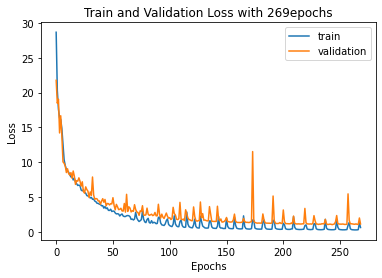

In [16]:
patience=25
# plotting training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [17]:
predict1=np.zeros((4096,))
for i in range((test_size-3)*l2r,(test_size-2)*l2r):
    predict1[(i-(test_size-3)*l2r)*os:(i-(test_size-3)*l2r+1)*os,]=predictions[i]
    
predict2=np.zeros((4096,))
for i in range((test_size-2)*l2r,(test_size-1)*l2r):
    predict2[(i-(test_size-2)*l2r)*os:(i-(test_size-2)*l2r+1)*os,]=predictions[i]
    
predict3=np.zeros((4096,))
for i in range((test_size-1)*l2r,test_size*l2r):
    predict3[(i-(test_size-1)*l2r)*os:(i-(test_size-1)*l2r+1)*os,]=predictions[i]

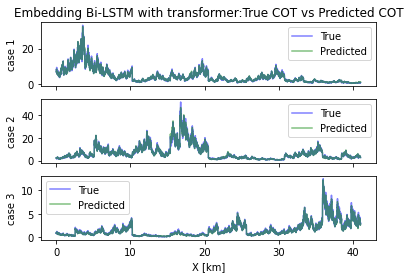

In [26]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/Bi-LSTM with transformer embedding predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Embedding Bi-LSTM with transformer:True COT vs Predicted COT")
ax.plot(x[:os*l2r],data[num-3,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict1,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r],data[num-2,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict2,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r],data[num-1,:os*l2r,3].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r],predict3,alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

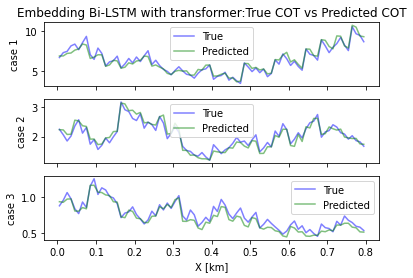

In [27]:
# plotting ----------------------------------------------------------------------------------------------------------------
fgnm = "plots/Bi-LSTM with transformer embedding predict"+"_"+str(ltype)+"_"+str(bsize)+"_"+str(len(history.history['val_loss'])-patience)+"_first_80_pixels"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True)

# plots the first 80 pixels in last three test images

#plot the third last profile
ax = axs[0]
ax.set_title(r'Embedding Bi-LSTM with transformer:True COT vs Predicted COT')
ax.plot(x[:os*l2r][:80],data[num-3,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict1[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 1") 

#plot the second last profile
ax = axs[1]
ax.plot(x[:os*l2r][:80],data[num-2,:os*l2r,3][:80].T,alpha=0.5,color="blue") 
ax.plot(x[:os*l2r][:80],predict2[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 2")  

# plot the last profile
ax = axs[2]
ax.plot(x[:os*l2r][:80],data[num-1,:os*l2r,3][:80].T,alpha=0.5,color="blue")
ax.plot(x[:os*l2r][:80],predict3[:80],alpha=0.5,color="green")
ax.legend(["True", "Predicted"])
ax.set_ylabel(r"case 3")  
ax.set_xlabel('X [km]')

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')